[Click this to download the run_clm.py file. drag it into the runtime before running code.](https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_clm.py)

# Installs/Imports

In [6]:
!pip install -q condacolab
import condacolab
condacolab.install()
# check that the condacolab installation went smoothly


✨🍰✨ Everything looks OK!


In [7]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [8]:
#installs
!pip install fair-esm
!pip install pytorch-lightning
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade torch
!pip install --upgrade transformers
!pip install git+https://github.com/huggingface/transformers
!pip install transformers[torch]

#import modules

import pandas as pd
from tqdm import tqdm
import pickle
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt
import random
import io
from google.colab import drive
from transformers import EsmModel, EsmTokenizer, EsmConfig, AutoTokenizer
import pandas as pd
from transformers import pipeline

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8rx5q8h_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8rx5q8h_
  Resolved https://github.com/huggingface/transformers to commit 17b06e2c6650de162e7954babf6224c1975c2852
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Mounting Drive

In [9]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading in/Cleaning Anti-CRISPR Sequences

In [10]:
#loading dataset

path_to_590_folder ='/content/drive/MyDrive/Pranay Vure/Individual Project 2/Part A Data'

# Read file using pd.read_csv()
data = pd.read_csv(f'{path_to_590_folder}/anti_crispr.csv')

# print dataset size
print('size of dataset: ', len(data))

# view the first 5 rows of the dataset
data.head()

size of dataset:  4433


Unnamed: 0                                           Sequence  Anti-CRISPR?
0           0  MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...             0
1           1  MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...             0
2           2  MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...             0
3           3  MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...             0
4           4  MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...             0

I only want to train on the ones that are actually anti-CRISPRs, so I'll select only the rows with a "1" in the Anti-CRISPR? column.

In [11]:
data = data[data['Anti-CRISPR?'] == 1]
print(data.shape)
data.head()

(433, 3)


Unnamed: 0                                           Sequence  \
16          16  MFNKAEIMKQAWNWFTDSNVWLSDIEWVSYTDKEKTFSVCLKAAWS...   
22          22  MTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITK...   
26          26  MDEIEDLSDLPMPRFIWGFAVIAGKGGEVMHDEFEYLTHTRSPRFT...   
45          45  MIDFNSIDHAIALIQKDPEQANAIAGEYAYQMAREAYEIASESGFG...   
52          52  MTTYYFSETSNINAYATAEALKAQTLADAKREASRRQCFQGTTLKI...   

    Anti-CRISPR?  
16             1  
22             1  
26             1  
45             1  
52             1

these sequences have been saved to '/content/drive/MyDrive/Pranay Vure/Individual Project 2/Part A Data/Positive_AntiCRISPRs.csv' for later use

# Split into train and val via random split. DEPRACATED - DON'T RUN THIS!!! HAS BEEN MIGRATED TO A CLUSTERING APPROACH!

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the sequences from the text file
with open('/content/drive/MyDrive/Pranay Vure/Individual Project 2/Part A Data/Anti CRISPR sequences.txt', 'r') as file:
    sequences = file.read().splitlines()

# Split the sequences into training and validation sets
train_seqs, val_seqs = train_test_split(sequences, test_size=0.1, random_state=42)  # Adjust the test_size as per the required split ratio

# Save the training sequences to a file
with open('train_sequences.txt', 'w') as file:
    for seq in train_seqs:
        file.write(f"{seq}\n")

# Save the validation sequences to a file
with open('val_sequences.txt', 'w') as file:
    for seq in val_seqs:
        file.write(f"{seq}\n")


# Splitting into train/val via clustering

i decided to split my data into training and validation using a clustering approach, where i cluster all of my data using mmseqs and then split the sequences in each cluster into either train or test with 80% being train and the other 20% being test. for clusters with only one protein, i sent this sequence to the training set.

In [12]:
!conda install -c conda-forge -c bioconda mmseqs2
import pandas as pd
!pip install bio
from Bio import SeqIO

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mmseqs2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aria2-1.37.0               |       h347180d_1         1.6 MB  conda-forge
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    gawk-5.3.0                 |       ha916aea_0         1.1 MB  conda-forge
    gettext-0.21.1             |       h27087fc_0         4.1 MB  conda-forge
    gmp-6.3.0                  |       h59595ed_1         556 KB  conda-forge
    l

In [14]:
# add an ID for clustering
data['id'] = [f'seq{i}' for i in range(len(data))]
data

Unnamed: 0                                           Sequence  \
0              0  MNSYLLLLMVSLLTCIGQLCQKQAAQCWEQPQARRLNLTLRWLAIA...   
1              1  MPDSSTALRILVYSDNVQTRERVMRALGKRLHPDLPDLTYVEVATG...   
2              2  MSNINVIDILKESDALLEGHFLLSSGRHSNRYCQCAKLLQCPQKAE...   
3              3  MARIAGINIPDHKHAVIALTSIYGVGKTRSKAILAAAGIAEDVKIS...   
4              4  MPSFDIVSEVDLQEARNAVDNASREVESRFDFRNVEASFELNDASK...   
...          ...                                                ...   
4428        4428  MAHNHWCNLFSVALVCVVALVMVQYSVAQNSPQDYVDAHNAARSAV...   
4429        4429  MVAVYPGSFDPITLGHVDIIKRALSIFDELVVLITENPRKRCLFSL...   
4430        4430  MSMVKEFKEFALKGNVMDLAVGVIIGGAFSTIVNSIVKDLIMPVVG...   
4431        4431  MLDQQTINIIKATVPVLKEHGVTITTTFYKNLFAKHPEVRPLFDMG...   
4432        4432  MERTFAIIKPDAVERRLAGTVIDRIEANGFTIVGMKKIKLSKEQAG...   

      Anti-CRISPR?       id  
0                0     seq0  
1                0     seq1  
2                0     seq2  
3                0     seq3  
4                0     seq4  
...            ...      ...  
4428             0  seq4428  
4429             0  seq4429  
4430             0  seq4430  
4431             0  seq4431  
4432             0  seq4432  

[4433 rows x 4 columns]

In [15]:
# write the fasta
onedata =data[data['Anti-CRISPR?']==1].reset_index(drop=True)
with open('one.fasta', 'w') as f:
  for i in range(len(onedata)):
    id = onedata.loc[i,'id']
    seq = onedata.loc[i,'Sequence']
    f.write(f'>{id}\n{seq}\n')

# check what you wrote - make sure it looks right
with open('one.fasta', 'r') as f:
  lines = f.readlines()
  print(''.join(lines[0:6]))

>seq16
MFNKAEIMKQAWNWFTDSNVWLSDIEWVSYTDKEKTFSVCLKAAWSKAKEEVKEVEKEIKHISKSEELKAWNWAERKLGLRFNISDDEKFTSVKDETKQHFGLSVWACAMKAVKLHNDLFPQTAA
>seq22
MTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK
>seq26
MDEIEDLSDLPMPRFIWGFAVIAGKGGEVMHDEFEYLTHTRSPRFTCRVVELEDMPAESEEDAIDGRIVHDDDPSRMFYITDAGMALVNFQLFDKMPDKQKLKRICDEAIANWMLRREFLDEEEDD



In [16]:
!mmseqs easy-cluster one.fasta clusterRes_ones mmseqs_results --min-seq-id 0.3 -c 0.5 --cov-mode 0

Create directory mmseqs_results
easy-cluster one.fasta clusterRes_ones mmseqs_results --min-seq-id 0.3 -c 0.5 --cov-mode 0 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.5
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residu

In [17]:
fasta_sequences = SeqIO.parse(open('clusterRes_ones_rep_seq.fasta'),'fasta')
id_list = []
seq_list = []

for fasta in fasta_sequences:
  id, sequence = fasta.id, str(fasta.seq)

  id_list.append(id)
  seq_list.append(sequence)

cluster_reps = pd.DataFrame(
    data = {
        'representative id': id_list,
        'sequence': seq_list
    }
)

print('Total clusters: {}'.format(len(cluster_reps)))
cluster_reps.head()

Total clusters: 40


representative id                                           sequence
0             seq16  MFNKAEIMKQAWNWFTDSNVWLSDIEWVSYTDKEKTFSVCLKAAWS...
1             seq45  MIDFNSIDHAIALIQKDPEQANAIAGEYAYQMAREAYEIASESGFG...
2             seq74  MTIKLLDEFLKKHDLTRYQLSKLTGISQNTLKDQNEKPLNKYTVSI...
3            seq167  MTITTAQKRYYDAMNEFEAITSKELEQTPEFSQDLLNDSDYLVITK...
4            seq261  MLYSEKVMDHFMHPRNVGEMENPSGVGEVGNAKCGDIMRMYLKIDE...

In [18]:
clusters = pd.read_csv(f'clusterRes_ones_cluster.tsv',sep='\t',header=None)
print('Total cluster members: {}'.format(len(clusters)))
print('All sequences were clustered: {}'.format(len(clusters)==len(data)))
clusters = clusters.rename(columns={
    0: 'representative id',
    1: 'member id'
})
clusters.head()

Total cluster members: 433
All sequences were clustered: False


representative id member id
0             seq16     seq16
1             seq16    seq171
2             seq16    seq200
3             seq16    seq276
4             seq16    seq284

In [19]:
clusters = pd.merge(clusters,
                    onedata.rename(columns={'id': 'member id',
                                            'Length':'length',
                                            'Sequence':'sequence'}),
                    on='member id',how='left')
clusters

representative id member id  Unnamed: 0  \
0               seq16     seq16          16   
1               seq16    seq171         171   
2               seq16    seq200         200   
3               seq16    seq276         276   
4               seq16    seq284         284   
..                ...       ...         ...   
428           seq1513   seq4080        4080   
429           seq1781   seq1781        1781   
430           seq2127   seq2127        2127   
431           seq2197   seq2197        2197   
432           seq2197    seq353         353   

                                              sequence  Anti-CRISPR?  
0    MFNKAEIMKQAWNWFTDSNVWLSDIEWVSYTDKEKTFSVCLKAAWS...             1  
1    MYNKAEIMKQAWNWFNDSNIWLSDIEWVSYTDKEKSFSVCLKAAWS...             1  
2    MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...             1  
3    MYNKAEIMKQAWNWFNNSNVWLSDIEWVSYTDKEKTFSVCLKAAWS...             1  
4    MYNKAEIMKQAWNWFNDSNIWLSDIEWVSYTDKEKSFSVCLKAAWS...             1  
..                                                 ...           ...  
428  MKVPAFFAANILTIEQIIEAINNDGSAMTSAPEIAGYYAWDAATDA...             1  
429  MSRPTVVTVTETPRNPGSYEVNVERDGKMVVGRARAGSDPGAAAAK...             1  
430  MAYGKSRYNSYRKRSFNRSNKQRREYAQEMDRLEKAFENLDGWYLS...             1  
431  MRFTSPSRTIPSICLAIYGCGQLDRVADFINNSGEYVEDGVTFTPG...             1  
432  MRFTSPSRTIPSICLAIYGCGQLDRVADFINNSGEYVEDGVTFTPG...             1  

[433 rows x 5 columns]

In [20]:
import pandas as pd

# Assuming 'clusters' is your DataFrame and it contains 'representative id' and 'member id' columns

# Group by 'representative id' and count the number of 'member id' to find the cluster size
cluster_sizes = clusters.groupby('representative id').size().reset_index(name='cluster_size')

# Sort the resulting DataFrame by 'cluster_size' in descending order
clustersgb = cluster_sizes.sort_values(by='cluster_size', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
print(clustersgb)


   representative id  cluster_size
0              seq74           112
1             seq167            85
2              seq16            53
3            seq4074            44
4             seq557            23
5            seq3440            13
6             seq895            13
7            seq2483            12
8            seq3652            11
9            seq3014            10
10           seq2491            10
11           seq1504             8
12           seq3324             4
13           seq1513             3
14           seq4010             2
15           seq2197             2
16           seq3369             2
17           seq2547             2
18           seq2437             2
19           seq3145             2
20           seq2127             1
21           seq1781             1
22           seq1017             1
23            seq261             1
24           seq3441             1
25           seq3361             1
26           seq3236             1
27           seq2774

In [21]:
# get a sense of cluster quality
print('Total clusters: {}'.format(len(clustersgb)))
print('\tTotal sequences: {}'.format(sum(clustersgb['cluster_size'])))
print('\nNumber of clusters of size 1: {}'.format(len(clustersgb[clustersgb['cluster_size']==1])))
print('\tTotal sequences in size-1 clusters: {}'.format(sum(clustersgb[clustersgb['cluster_size']==1]['cluster_size'])))
print('Number of clusters of size > 1: {}'.format(len(clustersgb[clustersgb['cluster_size']>1])))
print('\tTotal sequences in size >1 clusters: {}'.format(sum(clustersgb[clustersgb['cluster_size']>1]['cluster_size'])))

Total clusters: 40
	Total sequences: 433

Number of clusters of size 1: 20
	Total sequences in size-1 clusters: 20
Number of clusters of size > 1: 20
	Total sequences in size >1 clusters: 413


In [24]:
clusters

representative id member id  Unnamed: 0  \
0               seq16     seq16          16   
1               seq16    seq171         171   
2               seq16    seq200         200   
3               seq16    seq276         276   
4               seq16    seq284         284   
..                ...       ...         ...   
428           seq1513   seq4080        4080   
429           seq1781   seq1781        1781   
430           seq2127   seq2127        2127   
431           seq2197   seq2197        2197   
432           seq2197    seq353         353   

                                              sequence  Anti-CRISPR?  
0    MFNKAEIMKQAWNWFTDSNVWLSDIEWVSYTDKEKTFSVCLKAAWS...             1  
1    MYNKAEIMKQAWNWFNDSNIWLSDIEWVSYTDKEKSFSVCLKAAWS...             1  
2    MYNKSEIMQQAWNWFRDSSVWLSDIEWVSYTDKEKTFSVCLKAAWS...             1  
3    MYNKAEIMKQAWNWFNNSNVWLSDIEWVSYTDKEKTFSVCLKAAWS...             1  
4    MYNKAEIMKQAWNWFNDSNIWLSDIEWVSYTDKEKSFSVCLKAAWS...             1  
..                                                 ...           ...  
428  MKVPAFFAANILTIEQIIEAINNDGSAMTSAPEIAGYYAWDAATDA...             1  
429  MSRPTVVTVTETPRNPGSYEVNVERDGKMVVGRARAGSDPGAAAAK...             1  
430  MAYGKSRYNSYRKRSFNRSNKQRREYAQEMDRLEKAFENLDGWYLS...             1  
431  MRFTSPSRTIPSICLAIYGCGQLDRVADFINNSGEYVEDGVTFTPG...             1  
432  MRFTSPSRTIPSICLAIYGCGQLDRVADFINNSGEYVEDGVTFTPG...             1  

[433 rows x 5 columns]

In [25]:
import pandas as pd
import numpy as np

# Assuming 'clusters' DataFrame is already loaded

# Split sequences 80% for training, 20% for testing, 100% if only one member
def split_sequences(df):
    train, test = [], []
    for _, group in df.groupby('representative id'):
        if len(group) == 1:
            # All single-member clusters go to training
            train.extend(group['sequence'].tolist())
        else:
            # Splitting sequences according to the 80%-20% rule
            train_size = int(np.ceil(len(group) * 0.8))  # Use ceil to ensure at least one member goes to training
            shuffled = group.sample(frac=1)  # Shuffle the group to randomize selection
            train.extend(shuffled.iloc[:train_size]['sequence'].tolist())
            test.extend(shuffled.iloc[train_size:]['sequence'].tolist())
    return train, test

# Splitting the sequences
train_sequences, test_sequences = split_sequences(clusters)

# Writing sequences to text files
with open('train_sequences.txt', 'w') as f_train:
    for seq in train_sequences:
        f_train.write(f"{seq}\n")

with open('test_sequences.txt', 'w') as f_test:
    for seq in test_sequences:
        f_test.write(f"{seq}\n")


# Loading in ProtGPT2

In [ ]:
from transformers import pipeline
protgpt2 = pipeline('text-generation', model="nferruz/ProtGPT2")

# Finetuning on a set of user-defined sequences

In [28]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 57.6 MB/s eta 0:00:00


finetuning using run_clm. originally started with a low number of epochs (5) to ensure that the model would run. then moved to a higher value (150). Also started with a much higher batch size, but ran into RAM issues. Decided to lower batch size to 2 as a result. The final hyperparameter is learning rate, which I decided to leave at 3e-04. This seemed to be a learning rate that allowed my loss to continually decrease, as shown in my loss curve. With more time I would've tried to find a more optimal learning rate, but for the purpose of this model, this current learning rate will do.

In [29]:
!python run_clm.py \
  --model_name_or_path nferruz/ProtGPT2 \
  --train_file train_sequences.txt \
  --validation_file test_sequences.txt \
  --tokenizer_name nferruz/ProtGPT2 \
  --num_train_epochs 150 \
  --logging_steps 1 \
  --logging_dir 'logs' \
  --do_train \
  --do_eval \
  --output_dir '/content/drive/MyDrive/Pranay Vure/Individual Project 2/clustered_model' \
  --overwrite_output_dir \
  --learning_rate 3e-04 \
  --per_device_train_batch_size 2 \
  --evaluation_strategy epoch

04/03/2024 15:02:23 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
04/03/2024 15:02:23 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
e

# Loss curves & metrics

went into the model .readme to find my eval data. it can be found in my clustermodel output folder. i pasted it below and proceeded with graphing.

   Training Loss  Epoch  Step  Validation Loss  Accuracy
0         3.0667    1.0     8           2.7361    0.6217
1         0.7552    2.0    16           2.4598    0.6422
2         0.5330    3.0    24           2.2439    0.6510
3         0.5313    4.0    32           1.9893    0.6755
4         0.2498    5.0    40           1.7996    0.7364


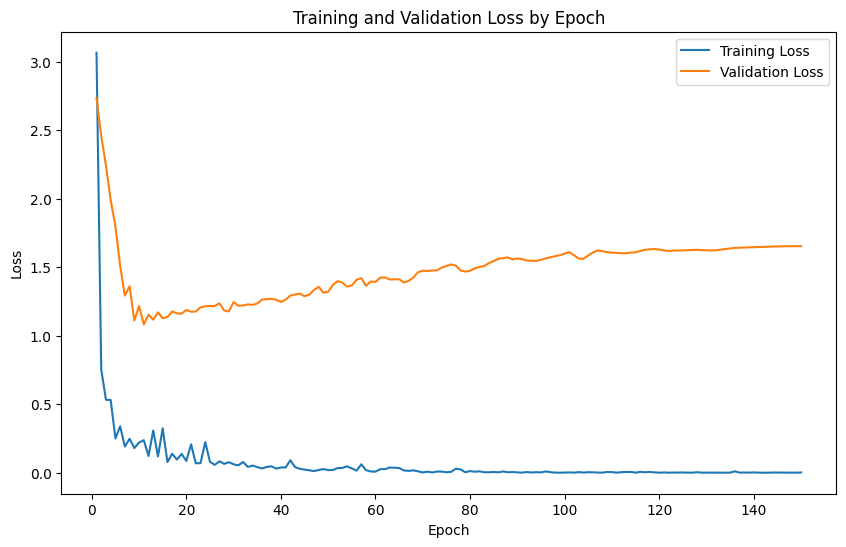

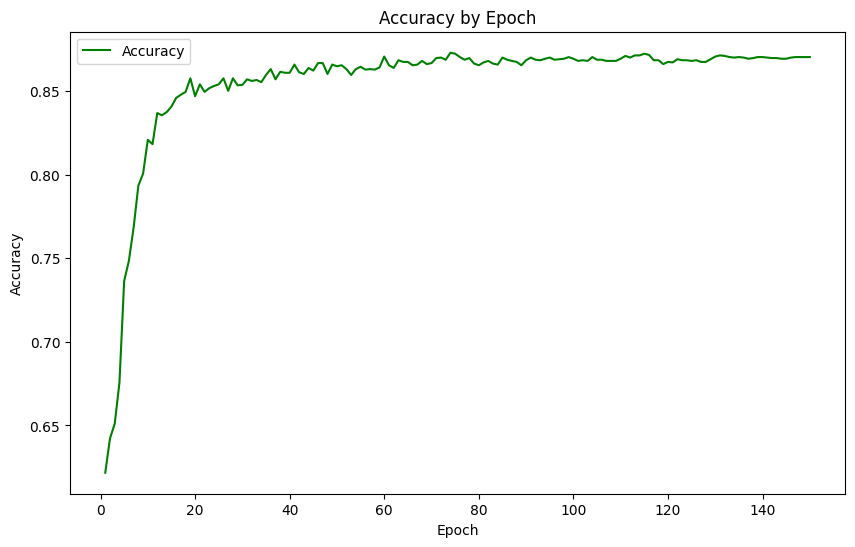

In [32]:
import pandas as pd
import re

# Path to your data file
data_file_path = '/content/drive/MyDrive/Pranay Vure/Individual Project 2/clustered_model/eval_results.txt'

# Initialize lists to store the extracted data
training_losses = []
epochs = []
steps = []
validation_losses = []
accuracies = []

# Open the data file and process each line
with open(data_file_path, 'r') as file:
    for line in file:
        # Use regular expression to match and extract the data values
        match = re.search(r'\|\s*(\d+\.\d+)\s*\|\s*(\d+\.\d+)\s*\|\s*(\d+)\s*\|\s*(\d+\.\d+)\s*\|\s*(\d+\.\d+)\s*\|', line)
        if match:
            training_losses.append(float(match.group(1)))
            epochs.append(float(match.group(2)))
            steps.append(int(match.group(3)))
            validation_losses.append(float(match.group(4)))
            accuracies.append(float(match.group(5)))

# Create a DataFrame
df = pd.DataFrame({
    'Training Loss': training_losses,
    'Epoch': epochs,
    'Step': steps,
    'Validation Loss': validation_losses,
    'Accuracy': accuracies
})

# Now df contains your data and you can work with it
print(df.head())  # For example, print the first few rows

# To visualize, you can plot directly from the DataFrame
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Accuracy'], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()
plt.show()


# Model Metrics

***** eval metrics *****
  epoch                   =      150.0
  eval_accuracy           =     0.8703
  eval_loss               =     1.6545
  eval_runtime            = 0:00:00.46
  eval_samples            =          3
  eval_samples_per_second =      6.398
  eval_steps_per_second   =      2.133
**  perplexity              =     5.2307**

# Loading in Finetuned Model

In [34]:
model_path = '/content/drive/MyDrive/Pranay Vure/Individual Project 2/clustered_model/'
tokenizer_path = '/content/drive/MyDrive/Pranay Vure/Individual Project 2/clustered_model/'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [35]:
my_protgpt2 = pipeline('text-generation', model=model_path, tokenizer=tokenizer_path)

# Inference & Processing Generated Sequences

i'm making 5 just to show it works, i actually made 10 batches of 1000 sequences at a time.

In [36]:
sequences = my_protgpt2("<|endoftext|>", max_length=100, do_sample=True, top_k=950, repetition_penalty=1.1, num_return_sequences=5, eos_token_id=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [37]:
print(len(sequences))

5


In [38]:
from transformers import (
    CONFIG_MAPPING,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    default_data_collator,
    is_torch_xla_available,
    set_seed,
)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
model = AutoModelForCausalLM.from_pretrained(model_path).to(device)

In [41]:
cleanseqs = [seq['generated_text'][1:] for seq in sequences]

print(cleanseqs)

['|endoftext|>\nMKLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK\nMTITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYLDETLVQSTRLDIEDETYYINFVVTNEDDFKLATDEDKEKHDKQEVIIKSELN\nMTLTTVQKRYYDAMNEFEAITSKELEQTPEFSQDSLNDSDYLAVTKNE', '|endoftext|>\nMTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK\nMTITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYLDETLVQSTRLDIEDETYYINFVVTNEDDFKLATDEDKEKHDKQEVIIKSELN\nMTLTTVQKRYYDAMNEFEAITSKELEQTPEFSQDSLNDSDYLAVTKNE', '|endoftext|>\nMTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK\nMTITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYLDETLVQSTRLDIEDETYYINFVVTNEDDFKLATDEDKEKHDKQEVIIKSELN\nMTLTTVQKRYYDAMNEFEAITSKELEQTPEFSQDSLNDSDYLAVTKNE', '|endoftext|>\nMTTTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSL

In [42]:
cleanseqs

['|endoftext|>\nMKLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK\nMTITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYLDETLVQSTRLDIEDETYYINFVVTNEDDFKLATDEDKEKHDKQEVIIKSELN\nMTLTTVQKRYYDAMNEFEAITSKELEQTPEFSQDSLNDSDYLAVTKNE',
 '|endoftext|>\nMTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK\nMTITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYLDETLVQSTRLDIEDETYYINFVVTNEDDFKLATDEDKEKHDKQEVIIKSELN\nMTLTTVQKRYYDAMNEFEAITSKELEQTPEFSQDSLNDSDYLAVTKNE',
 '|endoftext|>\nMTLTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVALCSLSTDECEYDTNLYLDEKLVDYSTVDVNGVTYYINIVETKDIDDLEIATDEDEMKSDNQEIILKSELK\nMTITTAQKRYYDAMNEFEAIISKELEQTPAFSQDLLNDSDYLVITKNEAYAVALCMLDDDKLYLDETLVQSTRLDIEDETYYINFVVTNEDDFKLATDEDKEKHDKQEVIIKSELN\nMTLTTVQKRYYDAMNEFEAITSKELEQTPEFSQDSLNDSDYLAVTKNE',
 '|endoftext|>\nMTTTRAQKKYAEAMHEFINMVDDFEESTPDFAKEVLHDSDYVVITKNEKYAVAL

# Sequence Perplexity Calculations

In [43]:
import torch
import pandas as pd
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def calculatePerplexity(sequence, model, tokenizer):
    input_ids = torch.tensor(tokenizer.encode(sequence)).unsqueeze(0)
    input_ids = input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    return math.exp(loss)

#process a list of sequences
def calculatePerplexitiesForSequences(sequences, model, tokenizer):
    perplexities = []
    for sequence in sequences:
        # Format the sequence as per your requirements
        formatted_sequence = formatSequence(sequence)
        ppl = calculatePerplexity(formatted_sequence, model, tokenizer)
        perplexities.append((sequence, ppl))
    # Create a DataFrame and sort it
    df = pd.DataFrame(perplexities, columns=['Sequence', 'Perplexity']).sort_values(by='Perplexity')
    return df

def formatSequence(sequence):
    #new line every 60 amino acids
    formatted_sequence = '\n'.join(sequence[i:i+60] for i in range(0, len(sequence), 60))
    return formatted_sequence
df = calculatePerplexitiesForSequences(cleanseqs, model, tokenizer)
print(df)


                                            Sequence  Perplexity
1  |endoftext|>\nMTLTRAQKKYAEAMHEFINMVDDFEESTPDFA...   58.565936
2  |endoftext|>\nMTLTRAQKKYAEAMHEFINMVDDFEESTPDFA...   58.565936
0  |endoftext|>\nMKLTRAQKKYAEAMHEFINMVDDFEESTPDFA...   62.822701
3  |endoftext|>\nMTTTRAQKKYAEAMHEFINMVDDFEESTPDFA...   65.794598
4  |endoftext|>\nMSYLISNGQIVAKTSATLASGQSVAFSGTRVS...   97.869350


# Sequence df export

In [ ]:
import pandas as pd
df.to_csv('df_10.csv', index=False)

[Click this link to go to the next part of my project: The classification of generated sequences as Anti-CRISPRs or non-Anti-CRISPRs](https://colab.research.google.com/drive/1m_6Kiylr89amJSUPgGXR_YQdQ4r7w_dZ)